# SMA Backtesting Class

In [1]:
# Python Module with Class for Vectorized Backtesting of SMA-based Strategies

In [2]:
import numpy as np
import pandas as pd
from scipy.optimize import brute

In [52]:
class SMAVectorBacktester(object):
    ''' Class for the vectorized backtesting of SMA-based trading strategies.

    Attributes
    ==========
    symbol: str
        RIC symbol with which to work with
    SMA1: int
        time window in days for shorter SMA
    SMA2: int
        time window in days for longer SMA
    start: str
        start date for data retrieval
    end: str
        end date for data retrieval

    Methods
    =======
    get_data:
        retrieves and prepares the base data set
    set_parameters:
        sets one or two new SMA parameters
    run_strategy:
        runs the backtest for the SMA-based strategy
    plot_results:
        plots the performance of the strategy compared to the symbol
    update_and_run:
        updates SMA parameters and returns the (negative) absolute performance
    optimize_parameters:
        implements a brute force optimizeation for the two SMA parameters
    '''

    def __init__(self, symbol, SMA1, SMA2, start, end):
        self.symbol = symbol
        self.SMA1 = SMA1
        self.SMA2 = SMA2
        self.start = start
        self.end = end
        self.results = None
        self.get_data()
        
    def get_data(self):
            ''' Retrieves and prepares the data.
            '''
            raw = pd.read_csv('pyalgo_eikon_eod_data.csv',
                            index_col=0, parse_dates=True).dropna()
            raw = pd.DataFrame(raw[self.symbol])
            raw = raw.loc[self.start:self.end]
            raw.rename(columns={self.symbol: 'price'}, inplace=True)
            # log return
            raw['return'] = np.log(raw / raw.shift(1))
            # simple moving averages
            raw['SMA1'] = raw['price'].rolling(self.SMA1).mean()
            raw['SMA2'] = raw['price'].rolling(self.SMA2).mean()
            self.data = raw

    def set_parameters(self, SMA1=None, SMA2=None):
        '''Updates SMA parameters and respective time series'''
        if SMA1 is not None:
            self.SMA1 = SMA1
            self.data['SMA1'] = self.data['price'].rolling(self.SMA1).mean()
        if SMA2 is not None:
            self.SMA2 = SMA2
            self.data['SMA2'] = self.data['price'].rolling(self.SMA2).mean()
    
    def run_strategy(self):
        ''' Backtests the trading strategy.
        '''
        data = self.data.copy().dropna()
        # only long
        data['position'] = np.where(data['SMA1'] > data['SMA2'], 1, 0)
        data['strategy'] = data['position'].shift(1) * data['return']
        data.dropna(inplace=True)
        data['creturns'] = data['return'].cumsum().apply(np.exp)
        data['cstrategy'] = data['strategy'].cumsum().apply(np.exp)
        self.results = data
        # gross performance of the strategy
        aperf = data['cstrategy'].iloc[-1]
        # out-/underperformance of strategy
        operf = aperf - data['creturns'].iloc[-1]
        return round(aperf, 2), round(operf, 2)

    def plot_results(self):
        ''' Plots the cumulative performance of the trading strategy
        compared to the symbol.
        '''
        if self.results is None:
            print('No results to plot yet. Run a strategy.')
        title = '%s | SMA1=%d, SMA2=%d' % (self.symbol,
                                                self.SMA1, self.SMA2)
        self.results[['creturns', 'cstrategy']].plot(title=title,
                                                        figsize=(10, 6))

    def update_and_run(self, SMA):
        ''' Updates SMA parameters and returns negative absolute performance
        (for minimazation algorithm).

        Parameters
        ==========
        SMA: tuple
            SMA parameter tuple
        '''
        self.set_parameters(int(SMA[0]), int(SMA[1]))
        return -self.run_strategy()[0]

    def optimize_parameters(self, SMA1_range, SMA2_range):
        ''' Finds global maximum given the SMA parameter ranges.

        Parameters
        ==========
        SMA1_range, SMA2_range: tuple
            tuples of the form (start, end, step size)
        '''
        opt = brute(self.update_and_run, (SMA1_range, SMA2_range), finish=None)
        return opt, -self.update_and_run(opt)


        



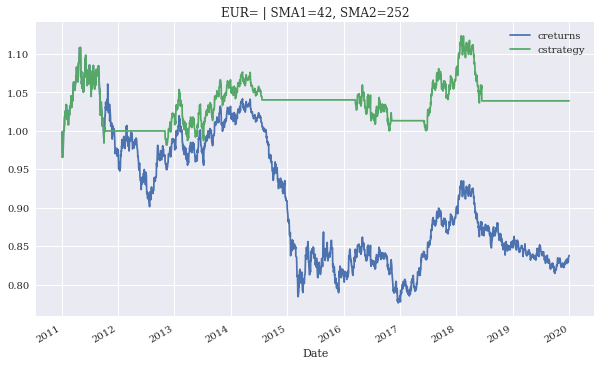

In [61]:
bt = SMAVectorBacktester(symbol="EUR=", SMA1=42, SMA2=252, start='2010-1-4', end='2019-12-31')
bt.run_strategy()
bt.plot_results()

<AxesSubplot:title={'center':'EUR/USD'}, xlabel='Date'>

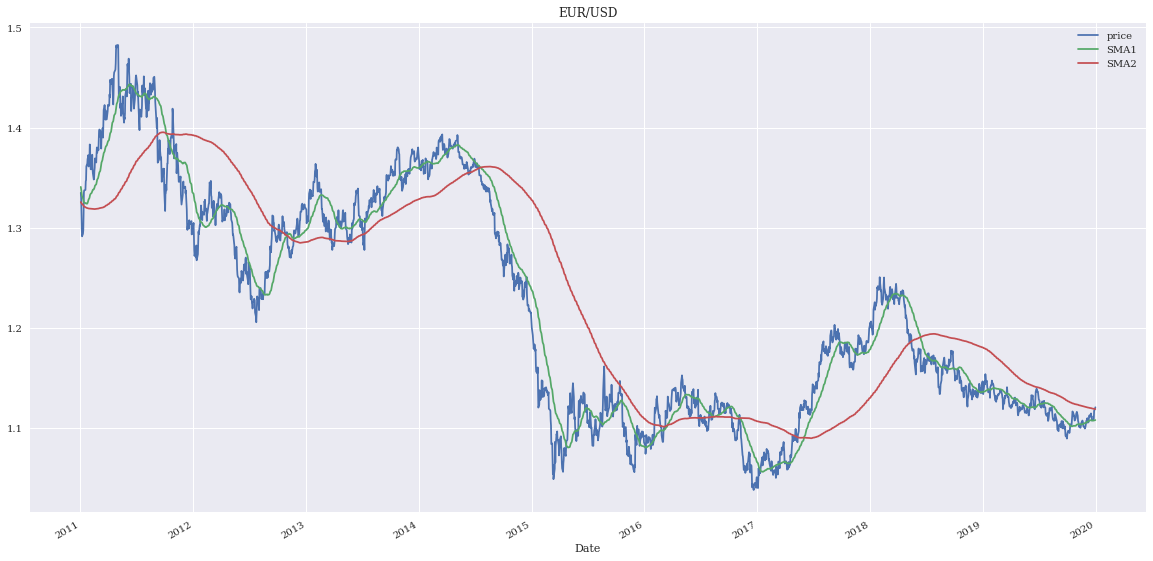

In [54]:
bt.results[['price', 'SMA1', 'SMA2']].plot(title='EUR/USD', figsize=(20,10))

In [82]:
import seaborn as sns

In [83]:
from matplotlib import pyplot as plt

<AxesSubplot:xlabel='Date', ylabel='price'>

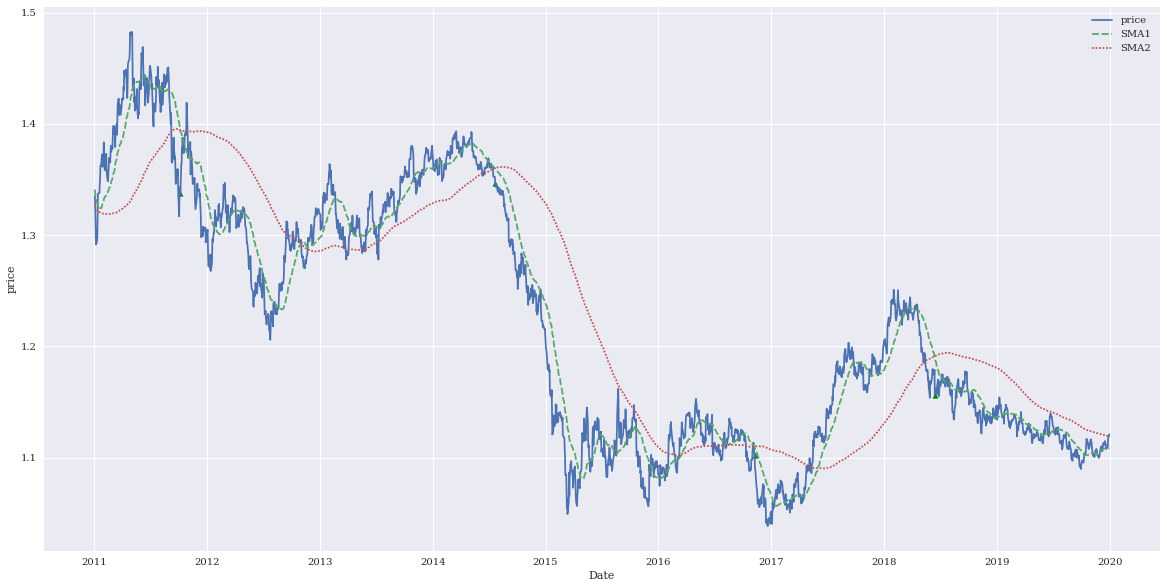

In [124]:
fig, ax = plt.subplots(figsize=(20,10))
sns.lineplot(data=bt.results[['price', 'SMA1', 'SMA2']], ax=ax)
sns.scatterplot(data=signals.query("signal == 'buy'").reset_index(), x='Date', y='price', color = 'g', marker = '^', ax=ax)
# sns.scatterplot(data=signals.query("signal == 'sell'").reset_index() ,color = 'r', marker = 'v', ax=ax)

In [119]:
signals.query("signal == 'buy'")[['price']]

,price
Date,
2011-10-07,1.3375
2014-07-22,1.3464
2016-11-08,1.1023
2018-06-14,1.1567


In [65]:
bt.results['SMA1'] - bt.results['SMA2']

Date
2011-01-03    0.015148
2011-01-04    0.013566
2011-01-05    0.011574
2011-01-06    0.009644
2011-01-07    0.007845
                ...   
2019-12-24   -0.011933
2019-12-26   -0.011788
2019-12-27   -0.011504
2019-12-30   -0.011202
2019-12-31   -0.010952
Length: 2264, dtype: float64

In [77]:
bt.results['signal'] = bt.results['position'].diff()

In [92]:
# sell 1
# buy -1
signals = bt.results[['price', 'signal']].query("(signal == 1) | (signal == -1)").copy()
signals['signal'] = signals['signal'].map({1.0:'sell', -1.0:'buy'})

In [97]:
signals.reset_index()

,Date,price,signal
0,2011-10-07,1.3375,buy
1,2012-11-01,1.2942,sell
2,2014-07-22,1.3464,buy
3,2016-03-17,1.1317,sell
4,2016-11-08,1.1023,buy
5,2017-06-02,1.1280,sell
6,2018-06-14,1.1567,buy


<AxesSubplot:xlabel='Date'>

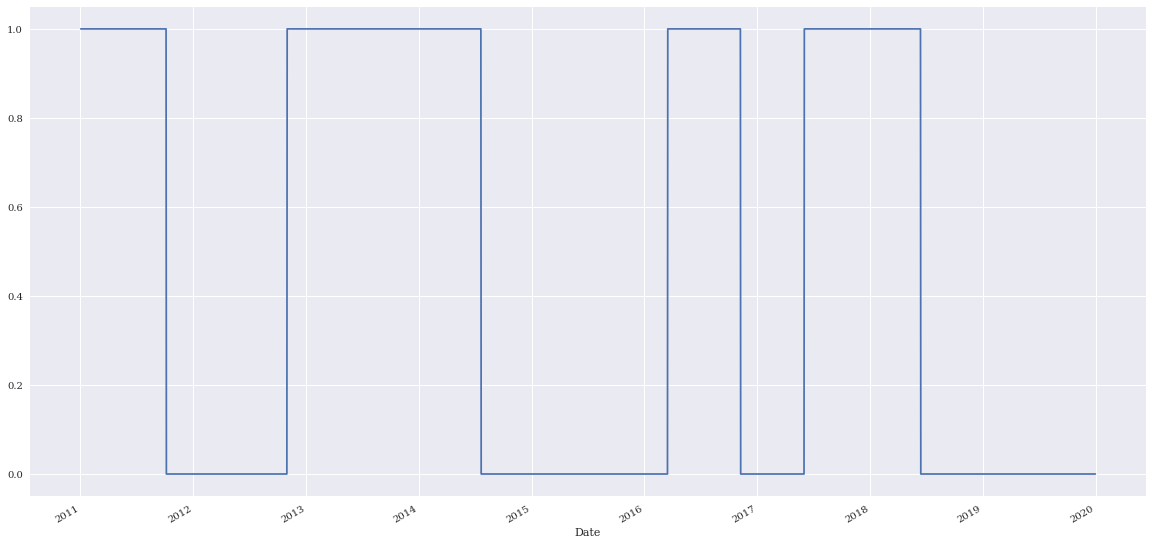

In [55]:
bt.results['position'].plot(figsize=(20,10))

In [20]:
data = bt.data.copy().dropna()
data['position'] = np.where(data['SMA1'] > data['SMA2'], 1, -1)
data['strategy'] = data['position'].shift(1) * data['return'] # why?
data.dropna(inplace=True)
data['creturns'] = data['return'].cumsum().apply(np.exp)
data['cstrategy'] = data['strategy'].cumsum().apply(np.exp)
results = data
# gross performance of the strategy
aperf = data['cstrategy'].iloc[-1]
# out-/underperformance of strategy
operf = aperf - data['creturns'].iloc[-1]
# round(aperf, 2), round(operf, 2)

In [28]:
%matplotlib inline 
from pylab import mpl, plt
plt.style.use('seaborn')
mpl.rcParams['savefig.dpi'] = 300
mpl.rcParams['font.family'] = 'serif'

In [27]:
data['position']

Date
2010-05-27    1
2010-05-28    1
2010-06-01    1
2010-06-02    1
2010-06-03    1
             ..
2019-12-24    1
2019-12-26    1
2019-12-27    1
2019-12-30    1
2019-12-31    1
Name: position, Length: 2416, dtype: int64

<AxesSubplot:xlabel='Date'>

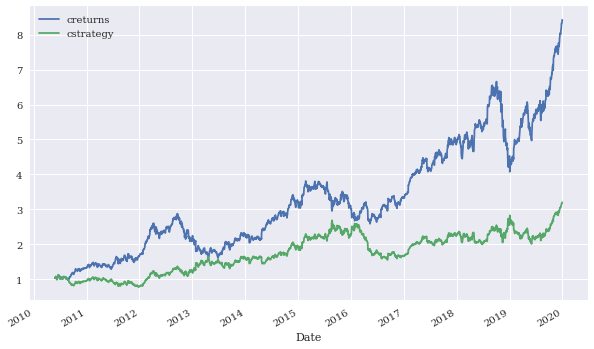

In [29]:
results[['creturns', 'cstrategy']].plot(figsize=(10, 6))